# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [72]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [73]:
from features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = ''

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

Clear previously loaded data.


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [74]:
from features import *

num_color_bins = 12 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [0]:
from __future__ import print_function



class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO:                                                                 #
      # Sample batch_size elements from the training data and their           #
      # corresponding labels to use in this round of gradient descent.        #
      # Store the data in X_batch and their corresponding labels in           #
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
      # and y_batch should have shape (batch_size,)                           #
      #                                                                       #
      # Hint: Use np.random.choice to generate indices. Sampling with         #
      # replacement is faster than sampling without replacement.              #
      #########################################################################
      p = np.random.choice(num_train,batch_size)
      X_batch = X[p]
      y_batch = y[p]
      
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
      #########################################################################
      # TODO:                                                                 #
      # Update the weights using the gradient and the learning rate.          #
      #########################################################################
      self.W+=-grad*learning_rate
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    scores = X.dot(self.W)
    y_pred=np.argmax(scores,axis=1)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)



In [0]:
import numpy as np
from random import shuffle

def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.shape) # initialize the gradient as zero

  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in xrange(num_train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    diff_count = 0
    for j in xrange(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1
      if margin > 0:
        diff_count += 1
        dW[:, j] += X[i] # gradient update for incorrect rows
        loss += margin
    # gradient update for correct row
    dW[:, y[i]] += -diff_count * X[i]

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train
  dW /= num_train
  dW += reg*W # regularize the weights
  # Add regularization to the loss.
  loss += 0.5 * reg * np.sum(W * W)

  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it dW.                #
  # Rather that first computing the loss and then computing the derivative,   #
  # it may be simpler to compute the derivative at the same time that the     #
  # loss is being computed. As a result you may need to modify some of the    #
  # code above to compute the gradient.                                       #
  #############################################################################



  return loss, dW


def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero

  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the structured SVM loss, storing the    #
  # result in loss.                                                           #
  #############################################################################
  num_train = X.shape[0]
  delta = 1.0
  
  scores = X.dot(W)
  correct_class_score = scores[np.arange(num_train), y]
  margins = np.maximum(0, scores - correct_class_score[:, np.newaxis] + delta)
  margins[np.arange(num_train), y] = 0
  loss = np.sum(margins)

  loss /= num_train # get mean
  loss += 0.5 * reg * np.sum(W * W) # regularization
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the structured SVM     #
  # loss, storing the result in dW.                                           #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################
  X_mask = np.zeros(margins.shape)
  # column maps to class, row maps to sample; a value v in X_mask[i, j]
  # adds a row sample i to column class j with multiple of v
  X_mask[margins > 0] = 1  
  # for each sample, find the total number of classes where margin > 0
  incorrect_counts = np.sum(X_mask, axis=1)
  X_mask[np.arange(num_train), y] = -incorrect_counts
  dW = X.T.dot(X_mask)

  dW /= num_train # average out weights
  dW += reg*W # regularize the weights
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return loss, dW


In [77]:
# Use the validation set to tune the learning rate and regularization strength


learning_rates = [1e-9, 1e-8, 1e-7,1e-4]
regularization_strengths = [5e4, 5e5, 5e6,0.25]

results = {}
best_val = -1
best_svm = None
loss_history = []
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for rate in learning_rates:
  for reg_str in regularization_strengths:
    svm = LinearSVM()
    loss_history = svm.train(X_train_feats, y_train, learning_rate=rate, reg=reg_str, num_iters=1500, verbose=True)
    y_val_pred = svm.predict(X_val_feats)
    v_accuracy = np.mean(y_val == y_val_pred)
    y_train_pred = svm.predict(X_train_feats)
    t_accuracy = np.mean(y_val == y_val_pred)
    if (v_accuracy > best_val):
      best_val = v_accuracy
      best_svm=svm
    results[rate,reg_str]=t_accuracy,v_accuracy

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 50.113488
iteration 100 / 1500: loss 49.700736
iteration 200 / 1500: loss 49.273908
iteration 300 / 1500: loss 48.886853
iteration 400 / 1500: loss 48.463956
iteration 500 / 1500: loss 48.090306
iteration 600 / 1500: loss 47.720404
iteration 700 / 1500: loss 47.299948
iteration 800 / 1500: loss 46.937320
iteration 900 / 1500: loss 46.551853
iteration 1000 / 1500: loss 46.187642
iteration 1100 / 1500: loss 45.825823
iteration 1200 / 1500: loss 45.432515
iteration 1300 / 1500: loss 45.092891
iteration 1400 / 1500: loss 44.727455
iteration 0 / 1500: loss 376.468278
iteration 100 / 1500: loss 341.490046
iteration 200 / 1500: loss 309.842808
iteration 300 / 1500: loss 281.213200
iteration 400 / 1500: loss 255.298327
iteration 500 / 1500: loss 231.861373
iteration 600 / 1500: loss 210.652623
iteration 700 / 1500: loss 191.452244
iteration 800 / 1500: loss 174.083695
iteration 900 / 1500: loss 158.373944
iteration 1000 / 1500: loss 144.142125
iteration 1100 / 1500: lo

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in add


iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 412.952647
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 3742.075826
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 15

In [78]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.452


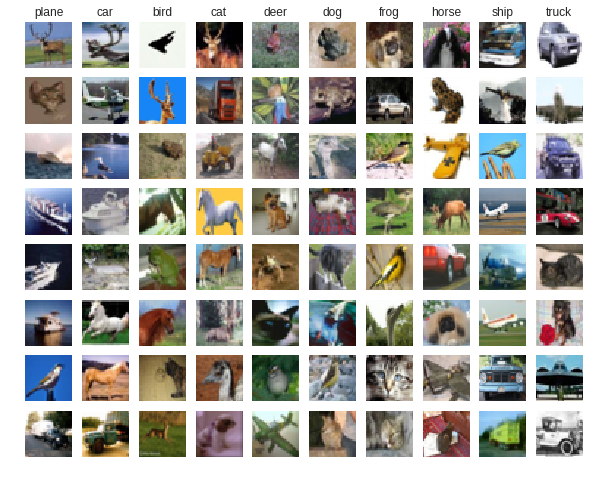

In [79]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [80]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 157)
(49000, 156)


In [0]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer.

  In other words, the network has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

  The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.

    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass
    scores = None
    num_train = X.shape[0]
    #############################################################################
    # TODO: Perform the forward pass, computing the class scores for the input. #
    # Store the result in the scores variable, which should be an array of      #
    # shape (N, C).                                                             #
    #############################################################################
    a1 = X.dot(W1)+b1
    a2=np.maximum(0,a1)
    scores=a2.dot(W2)+b2
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################
    
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores

    # Compute the loss
    loss = None
    #############################################################################
    # TODO: Finish the forward pass, and compute the loss. This should include  #
    # both the data loss and L2 regularization for W1 and W2. Store the result  #
    # in the variable loss, which should be a scalar. Use the Softmax           #
    # classifier loss.                                                          #
    #############################################################################
    scores-=np.max(scores,axis=1,keepdims = True)
    sum = np.sum(np.exp(scores), axis=1, keepdims=True)
    p = np.exp(scores)/sum
    loss = -np.sum(np.log(p[np.arange(num_train),y]))    
    loss/=num_train
    loss+=reg*(np.sum(W1*W1)+np.sum(W2*W2))
    
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    # Backward pass: compute gradients
    grads = {}
    #############################################################################
    # TODO: Compute the backward pass, computing the derivatives of the weights #
    # and biases. Store the results in the grads dictionary. For example,       #
    # grads['W1'] should store the gradient on W1, and be a matrix of same size #
    #############################################################################
    dW=p
    dW[range(N),y]-=1
    dW/=N
    grads['W2']=np.dot(a2.T,dW)
    grads['b2']=np.sum(dW,axis=0)
    
    d1=np.dot(dW,W2.T)
    d1[a2 <=0] = 0
    
    grads['W1']=np.dot(X.T,d1)
    grads['b1']=np.sum(d1,axis=0)    
    grads['W1']+=2*reg*W1
    grads['W2']+=2*reg*W2
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this neural network using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO: Create a random minibatch of training data and labels, storing  #
      # them in X_batch and y_batch respectively.                             #
      #########################################################################
      comb=np.random.choice(num_train,batch_size)
      X_batch = X[comb]
      y_batch = y[comb]
      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      #########################################################################
      # TODO: Use the gradients in the grads dictionary to update the         #
      # parameters of the network (stored in the dictionary self.params)      #
      # using stochastic gradient descent. You'll need to use the gradients   #
      # stored in the grads dictionary defined above.                         #
      #########################################################################
      self.params['W1']+=-learning_rate*grads['W1']
      self.params['W2']+=-learning_rate*grads['W2']
      self.params['b1']+=-learning_rate*grads['b1']
      self.params['b2']+=-learning_rate*grads['b2']
      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.

    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.

    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = None
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    ###########################################################################
    # TODO: Implement this function; it should be VERY simple!                #
    ###########################################################################
    a1 = X.dot(W1)+b1
    a2=np.maximum(0,a1)
    scores=a2.dot(W2)+b2
    y_pred=np.argmax(scores,axis=1)
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return y_pred




In [87]:
X_train_feats.shape

(49000, 156)

In [96]:

input_dim = X_train_feats.shape[1]
hidden_sizes=[512]

num_iters=[2500]
 
learning_rates = [3e-1]
print(learning_rates)
reg_strengths = [1e-3]
best_net = None
batch_sizes =[200]
best_accuracy = -1
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for size in hidden_sizes:
  for num in num_iters:
    for reg1 in reg_strengths:
      for rate in learning_rates:
        for b_size in batch_sizes:
         
          hidden_dim = size
          num_classes = 10
          net = TwoLayerNet(input_dim,hidden_dim, num_classes)
          # Train the network
          stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=num, batch_size=b_size,
                learning_rate=rate, learning_rate_decay=0.95,
                reg=reg1, verbose=True)
          # Predict on the validation set
          val_acc = (net.predict(X_val_feats) == y_val).mean()
          if (val_acc > best_accuracy):
            best_accuracy = val_acc
            best_net=net          
          print(val_acc,size,num,reg1,rate,b_size)  
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

[0.3]
iteration 0 / 2500: loss 2.302586
iteration 100 / 2500: loss 1.860360
iteration 200 / 2500: loss 1.479095
iteration 300 / 2500: loss 1.470955
iteration 400 / 2500: loss 1.407053
iteration 500 / 2500: loss 1.309448
iteration 600 / 2500: loss 1.236950
iteration 700 / 2500: loss 1.261419
iteration 800 / 2500: loss 1.342801
iteration 900 / 2500: loss 1.171478
iteration 1000 / 2500: loss 1.233932
iteration 1100 / 2500: loss 1.139950
iteration 1200 / 2500: loss 1.230915
iteration 1300 / 2500: loss 1.136245
iteration 1400 / 2500: loss 1.162781
iteration 1500 / 2500: loss 1.203447
iteration 1600 / 2500: loss 1.208743
iteration 1700 / 2500: loss 1.153916
iteration 1800 / 2500: loss 1.133209
iteration 1900 / 2500: loss 1.062191
iteration 2000 / 2500: loss 1.133507
iteration 2100 / 2500: loss 1.222749
iteration 2200 / 2500: loss 1.180477
iteration 2300 / 2500: loss 1.074086
iteration 2400 / 2500: loss 1.162961
0.593 512 2500 0.001 0.3 200


In [97]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.598
